In [1]:
%load_ext autoreload
%autoreload 2

# imports
import time

# library imports
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pacswg.timer import TimerClass
import pacswg

from exp_trace_utils import get_time_with_tz
import exp_trace_utils

In [2]:
# configs
server_address = 'http://localhost:3000'

# service_name = 'tfserving-resnetv2'
# slo_timeout = 

# service_name = 'bentoml-onnx-resnet50'
# slo_timeout = 

service_name = 'bentoml-iris'
service_url = f'{server_address}/proxy/{service_name}'
slo_timeout = 500
initial_batch_size = 5
bs_config = {
    'max_bs': 100,
    'min_bs': 1,
    'inc_step': 5,
    'dec_mult': 0.7,
}
average_timeout_ratio_threshold = 0.5

# service_name = 'tfserving-mobilenetv1'
# slo_timeout = 

# SLO Target
slo_target = slo_timeout * 0.8

# length of measurements used to estimate different batch size response times
upstream_rt_max_len = 1000

# disable controller?
disable_controller = True
if disable_controller:
    initial_batch_size = 1

# experiment info
cpu_m = 1000
ram_mb = 1000
base_rps = 50
rps_list = [base_rps] * 5 + [base_rps*2] * 5 + [base_rps*3] * 5 + [base_rps*4] * 5

controller = exp_trace_utils.SmartProxyController(
    server_address=server_address,
    service_name=service_name,
    slo_timeout=slo_timeout,
    initial_batch_size=initial_batch_size,
    bs_config=bs_config,
    average_timeout_ratio_threshold=average_timeout_ratio_threshold,
)

# Getting and Setting Stats and Configs

In [3]:
controller.set_initial_config()

{'serviceName': 'bentoml-iris',
 'upstreamUrl': 'http://bentoml-iris.default.kn.nima-dev.com/predict',
 'maxBufferTimeoutMs': 400,
 'maxBufferSize': 1,
 'isTFServing': False}

In [4]:
proxy_stats = controller.get_proxy_stats()
proxy_stats

{'maxBufferSize': 1,
 'averageMaxBufferSize': 1,
 'averageActualBatchSize': None,
 'maxBufferTimeoutMs': 400,
 'currentReplicaCount': 0,
 'currentReadyReplicaCount': 0,
 'currentConcurrency': 0,
 'averageConcurrency': 0,
 'averageArrivalRate': 0,
 'averageDepartureRate': 0,
 'averageDispatchRate': 0,
 'averageErrorRate': 0,
 'averageTimeoutRatio': None,
 'reponseTimeAverage': None,
 'reponseTimeP50': None,
 'reponseTimeP95': None,
 'batchResponseTimeStats': {}}

In [5]:

batch_rt_values = controller.update_batch_rt_values()
# batch_rt_values

In [6]:
# run a loop to monitor response times to test the functionality
# timer = TimerClass()

# batch_rt_values = {}
# for _ in tqdm(range(1*6)):
#     timer.tic()
#     controller.update_batch_rt_values()
#     while timer.toc() < 10:
#         time.sleep(.1)

# batch_rt_values = controller.get_batch_rt_values()
# batch_rt_values

In [7]:
def analyze_batch_results(batch_rt_values):
    batch_size_results = []
    for bs, vals in batch_rt_values.items():
        # print(bs, len(vals), np.mean(vals))
        batch_size_results.append({
            'batch_size': bs,
            'average_response_time': np.mean(vals),
            'median_response_time': np.median(vals),
            'p95_response_time': np.percentile(vals,95),
        })

    df_batch_size = pd.DataFrame(data=batch_size_results)
    df_batch_size = df_batch_size.sort_values(by='batch_size')
    return df_batch_size

def plot_key_vs_batch_size(key, df_batch_size):
    plt.figure()
    plt.plot(df_batch_size['batch_size'], df_batch_size[key], marker='x')
    prev_ylim = plt.gca().get_ylim()
    # relative average response time by batch size (linear scale)
    relative_scaled_response_time = df_batch_size['batch_size']/df_batch_size['batch_size'].iloc[0]*df_batch_size[key].iloc[0]
    # plot the linear baseline
    plt.plot(df_batch_size['batch_size'], relative_scaled_response_time, ls='--')
    plt.ylim(prev_ylim)
    plt.title(key)

# df_batch_size = analyze_batch_results(batch_rt_values)
# display(df_batch_size)
# plot_key_vs_batch_size('average_response_time', df_batch_size)
# plot_key_vs_batch_size('median_response_time', df_batch_size)
# plot_key_vs_batch_size('p95_response_time', df_batch_size)

# Perform Experiment and Log Results

In [8]:
# my imports
from helpers import kube
from helpers import workload
from helpers import util
from helpers import request_funcs

fetching imagenet v2
resizing images


  0%|          | 0/100 [00:00<?, ?it/s]

converting to bentoml files


  0%|          | 0/100 [00:00<?, ?it/s]

extracting base64 files


  0%|          | 0/100 [00:00<?, ?it/s]

preprocessing for mobilenet


  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
config_names = [
    'bentoml-iris-250m-512mb',
    'bentoml-onnx-resnet50-250m-512mb',
    'tfserving-resnetv2-250m-512mb',
    'tfserving-mobilenetv1-250m-512mb',
]

workload_configs = {}
for exp_config_name in config_names:
    exp_file = f"deployments/{exp_config_name}.json"
    workload_spec = util.load_json_file(exp_file)
    workload_configs[workload_spec['name']] = workload_spec

In [10]:
# deploy the function
request_limit_override = f"'cpu={cpu_m}m,memory={ram_mb}Mi'"
print('Request Limit Override:', request_limit_override)

workload_spec = workload_configs[service_name]
# override request and limit values
workload_spec['opts']['--request'] = request_limit_override
workload_spec['opts']['--limit'] = request_limit_override
kn_command = kube.get_kn_command(**workload_spec)
print(kn_command)
!{kn_command}
print('waiting for settings to converge')
time.sleep(10)

Request Limit Override: 'cpu=1000m,memory=1000Mi'
kn service apply bentoml-iris --image ghcr.io/nimamahmoudi/bentoml-iris-classifier:20210429201447 \
  --limit 'cpu=1000m,memory=1000Mi' \
  --request 'cpu=1000m,memory=1000Mi' \
  --port 5000 \
  -a autoscaling.knative.dev/target=1 \
  -a autoscaling.knative.dev/metric=concurrency
No changes to apply to service 'bentoml-iris'.
Service 'bentoml-iris' with latest revision 'bentoml-iris-00163' (unchanged) is available at URL:
http://bentoml-iris.default.kn.nima-dev.com
waiting for settings to converge


In [11]:
# call the request function with proper arguments
def call_request_func():
    request_func = request_funcs.workload_funcs[service_name]
    result = request_func(url=service_url)

    return {
        'response_time_ms': result['response_time_ms'],
        'request_id': result['headers']['X-Request-Id'],
        'queue_position': int(result['headers']['X-SmartProxy-queuePosition']),
        'received_at': exp_trace_utils.from_js_timestamp(int(result['headers']['X-SmartProxy-receivedAt'])),
        'response_at': exp_trace_utils.from_js_timestamp(int(result['headers']['X-SmartProxy-responseAt'])),
        'upstream_response_time': int(result['headers']['X-SmartProxy-upstreamResponseTime']),
        'upstream_request_count': int(result['headers']['X-SmartProxy-upstreamRequestCount']),
        'response_time_ms_server': int(result['headers']['X-SmartProxy-responseTime']),
        'queue_time_ms': int(result['headers']['X-SmartProxy-queueTime']),
    }

# adding exception handling to create worker func
def worker_func():
    try:
        return call_request_func()
    except Exception:
        print('exception occured:')
        traceback.print_exc()
        return None

worker_func()

{'response_time_ms': 5504.761,
 'request_id': 'ccf8b1d7-99d8-4c79-9210-3635b17a1ebe',
 'queue_position': 0,
 'received_at': datetime.datetime(2021, 6, 9, 19, 45, 36, 701000, tzinfo=<DstTzInfo 'America/Toronto' EDT-1 day, 20:00:00 DST>),
 'response_at': datetime.datetime(2021, 6, 9, 19, 45, 42, 197000, tzinfo=<DstTzInfo 'America/Toronto' EDT-1 day, 20:00:00 DST>),
 'upstream_response_time': 5493,
 'upstream_request_count': 1,
 'response_time_ms_server': 5496,
 'queue_time_ms': 3}

In [12]:
# perform the experiment

# start the controller
if disable_controller:
    controller.disable_controller()
    
controller.set_initial_config()
controller.start_control_thread()

# start workload generator
wg = pacswg.WorkloadGenerator(worker_func=worker_func, rps=0, worker_thread_count=300)
wg.start_workers()
timer = TimerClass()

print("============ Experiment Started ============")
print("Time Started:", get_time_with_tz())

for rps in tqdm(rps_list):
    wg.set_rps(rps)
    timer.tic()
    # apply each for one minute
    while timer.toc() < 60:
        wg.fire_wait()

# get the results
wg.stop_workers()
all_res = wg.get_stats()
total_reqs = len(all_res)
all_res = [d for d in all_res if d is not None]
success_reqs = len(all_res)

print("Total Requests Made:", total_reqs)
print("Successful Requests Made:", success_reqs)

Controller Disabled!!!
============ Experiment Started ============
Time Started: 2021-06-09 15:45:43.820063-04:00


  0%|          | 0/20 [00:00<?, ?it/s]

Total Requests Made: 136269
Successful Requests Made: 136269


In [13]:
# collect the results
df_res = pd.DataFrame(data=all_res)
# save the results
now = get_time_with_tz()
res_name = now.strftime('res-%Y-%m-%d_%H-%M-%S')
res_folder = f'results/trace2/{service_name}'
# make the directory and file names
! mkdir -p {res_folder}
requests_results_filename = f'{res_name}_reqs.csv'
proxy_results_filesname = f'{res_name}_proxy.csv'
if disable_controller:
    requests_results_filename.replace('.csv', '_no_controller.csv')
    proxy_results_filesname.replace('.csv', '_no_controller.csv')

df_res.to_csv(os.path.join(res_folder, requests_results_filename))
print('Results Name:', res_name)

Results Name: res-2021-06-09_16-05-46


In [14]:
# stop the controller to save the results
controller.stop_control_thread()

In [15]:
df_proxy_stats = pd.DataFrame(data=controller.acc_proxy_stats)
df_proxy_stats.to_csv(os.path.join(res_folder, proxy_results_filesname))
df_proxy_stats.head()

,maxBufferSize,averageMaxBufferSize,averageActualBatchSize,maxBufferTimeoutMs,currentReplicaCount,currentReadyReplicaCount,currentConcurrency,averageConcurrency,averageArrivalRate,averageDepartureRate,averageDispatchRate,averageErrorRate,averageTimeoutRatio,reponseTimeAverage,reponseTimeP50,reponseTimeP95,batchResponseTimeStats
0,1,1,NaN,400,2,2,0,0.3,0.05,0.00,0.05,0,0,NaN,NaN,NaN,{}
1,1,1,1.0,400,2,2,1,0.9,49.20,49.15,49.20,0,0,28.866376,24.0,35.0,"{'1': {'values': [14, 14, 14, 14, 14, 14, 14, ..."
2,1,1,1.0,400,63,63,2,37.4,45.80,45.65,45.80,0,0,304.968649,25.0,2677.9,"{'1': {'values': [13, 14, 14, 14, 14, 14, 14, ..."
3,1,1,1.0,400,63,63,1,0.8,49.15,49.10,49.15,0,0,291.602076,24.0,2620.4,"{'1': {'values': [13, 13, 14, 14, 14, 14, 14, ..."
4,1,1,1.0,400,2,2,0,0.7,50.00,50.00,50.00,0,0,24.250591,23.0,34.0,"{'1': {'values': [13, 14, 14, 14, 15, 15, 15, ..."


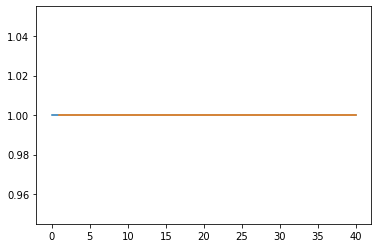

In [16]:
plt.plot(df_proxy_stats['averageMaxBufferSize'])
plt.plot(df_proxy_stats['averageActualBatchSize'])

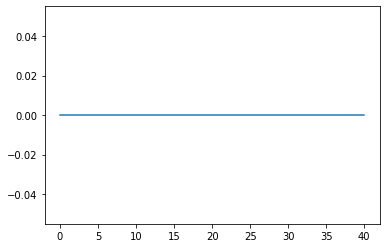

In [17]:
plt.plot(df_proxy_stats['averageTimeoutRatio'])

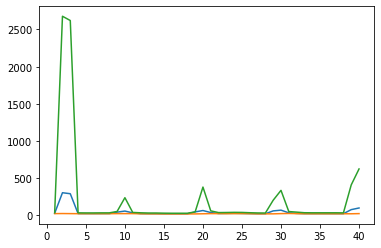

In [18]:
plt.plot(df_proxy_stats['reponseTimeAverage'])
plt.plot(df_proxy_stats['reponseTimeP50'])
plt.plot(df_proxy_stats['reponseTimeP95'])

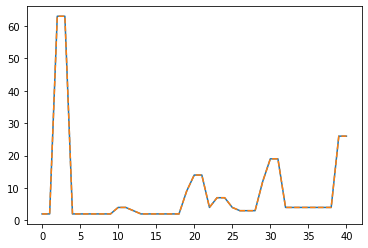

In [19]:
plt.plot(df_proxy_stats['currentReplicaCount'])
plt.plot(df_proxy_stats['currentReadyReplicaCount'], ls='--')

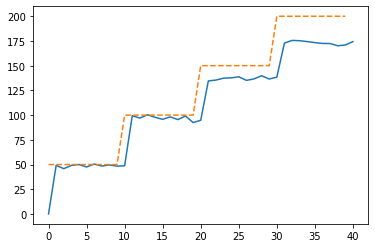

In [20]:
plt.plot(df_proxy_stats['averageArrivalRate'])
# measuremenst are once every 30s, but rps is once every minute
plt.plot(np.repeat(rps_list, 2), ls="--")